In [47]:
import pandas as pd
import numpy as np

import scipy.stats as sts
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

plt.rcParams['figure.figsize'] = (10, 8)
plt.style.use('seaborn')

In [2]:
ALPHA=0.05

In [3]:
data = pd.read_csv('ab_browser_test.csv')
data.head()

,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries
0,1,Browser #2,exp,23,32,19
1,3,Browser #4,exp,3,4,2
2,5,Browser #4,exp,29,35,16
3,6,Browser #4,control,12,6,0
4,7,Browser #4,exp,54,68,30


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 566134 entries, 0 to 566133
Data columns (total 6 columns):
userID              566134 non-null int64
browser             566134 non-null object
slot                566134 non-null object
n_clicks            566134 non-null int64
n_queries           566134 non-null int64
n_nonclk_queries    566134 non-null int64
dtypes: int64(4), object(2)
memory usage: 25.9+ MB


In [5]:
control = data[data['slot'] == 'control']
exp = data[data['slot'] == 'exp']

In [6]:
clicks_control = control.n_clicks.values
clicks_exp = exp.n_clicks.values

In [7]:
(clicks_exp.sum() - clicks_control.sum()) / clicks_control.sum() * 100

1.6135689824415809

In [8]:
def get_bootstrap_samples(x, B_sample=1):
    N = x.size 
    sample = np.random.choice(x, size=(N, B_sample), replace=True)
    
    if B_sample == 1:
        sample = sample.T[0]
    return sample

def efron_ci(x, alpha=ALPHA):
    left = np.quantile(x, alpha/2)
    right = np.quantile(x, 1-alpha/2)
    return left, right

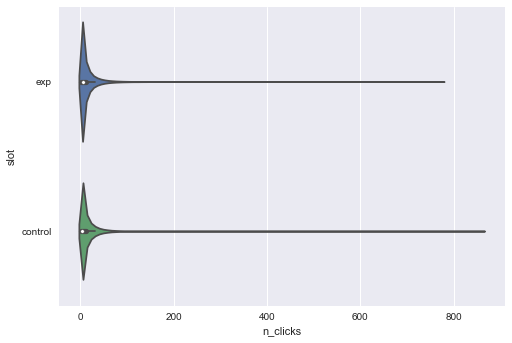

In [9]:
sns.violinplot(x=data['n_clicks'], y=data['slot'])

In [10]:
%%time
bootstrap_control = get_bootstrap_samples(clicks_control, 1000)
bootstrap_exp = get_bootstrap_samples(clicks_exp, 1000)

means_clicks_control = np.mean(bootstrap_control, axis=0)
means_clicks_exp = np.mean(bootstrap_exp, axis=0)

medians_clicks_control = np.median(bootstrap_control, axis=0)
medians_clicks_exp = np.median(bootstrap_exp, axis=0)

Wall time: 27.5 s


In [11]:
efron_ci(means_clicks_control), efron_ci(means_clicks_exp), efron_ci(means_clicks_control-means_clicks_exp)

((11.205962400809687, 11.352852270570787),
 (11.509072022160666, 11.66004306058669),
 (-0.4128437074133754, -0.19778405710970837))

In [12]:
efron_ci(medians_clicks_control), efron_ci(medians_clicks_exp), efron_ci(medians_clicks_control-medians_clicks_exp)

((4.0, 4.0), (5.0, 5.0), (-1.0, -1.0))

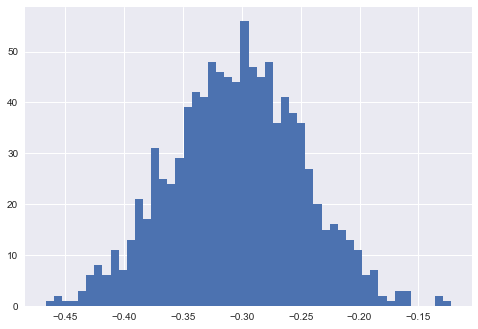

In [13]:
plt.hist(means_clicks_control-means_clicks_exp, bins=50);

In [14]:
n_boot_samples = 500
np.random.seed(0)

t_task_boot_samples = get_bootstrap_samples(clicks_control, n_boot_samples)

In [22]:
mean_t_task = np.mean(t_task_boot_samples, axis=0)
control_boot_chi_squared = np.sum((t_task_boot_samples - mean_t_task) ** 2, axis=0)

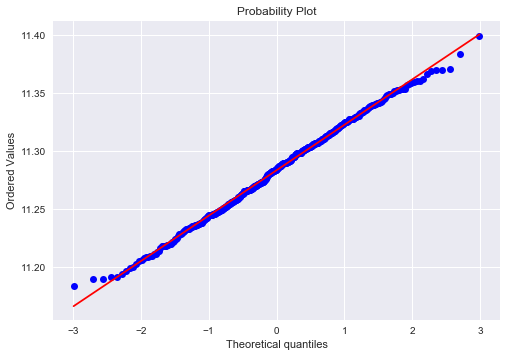

In [38]:
sts.probplot(mean_t_task, dist="norm", plot=plt);

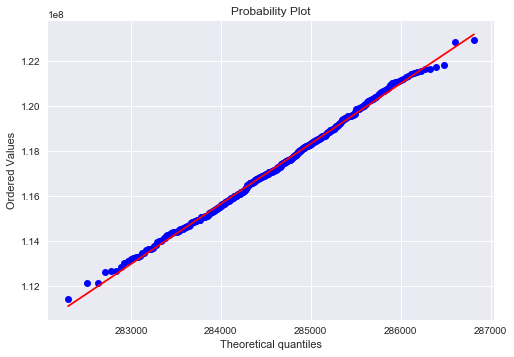

In [37]:
n = len(clicks_control)
sts.probplot(control_boot_chi_squared, dist="chi2", sparams=(n-1), plot=plt);

In [35]:
unique_clicks_control = control.groupby('userID', as_index=False).n_clicks.sum().n_clicks.values
unique_clicks_exp = exp.groupby('userID', as_index=False).n_clicks.sum().n_clicks.values

In [36]:
sts.mannwhitneyu(unique_clicks_control, unique_clicks_exp)

MannwhitneyuResult(statistic=38901259929.0, pvalue=4.3471471887604393e-75)

In [59]:
pvals = []

for browser in data.browser.unique():
    print(f'Browser: {browser}')
    subset_control = control[control['browser'] == browser]
    subset_exp = exp[exp['browser'] == browser]
    
    sample1 = subset_control.groupby('userID', as_index=False).n_clicks.sum().n_clicks.values
    sample2 = subset_exp.groupby('userID', as_index=False).n_clicks.sum().n_clicks.values
    
    pvalue = sts.mannwhitneyu(sample1, sample2)[1]
    print(f'P-value: {pvalue}')
    pvals.append(pvalue)
    
pvals = np.array(pvals)

Browser: Browser #2
P-value: 0.0272438604197241
Browser: Browser #4
P-value: 0.40760617658454984
Browser: Browser #14
P-value: 0.0
Browser: Browser #17
P-value: 0.03740060143010802
Browser: Browser #20
P-value: 0.45366656388735377
Browser: Browser #22
P-value: 0.2574055152210032


In [60]:
pvals < ALPHA

array([ True, False,  True,  True, False, False])

In [61]:
pvals_corrected = multipletests(pvals, method='holm')[1]

In [62]:
pvals_corrected < 0.05

array([False, False,  True, False, False, False])

In [63]:
pvals = []

for browser in data.browser.unique():
    print(f'Browser: {browser}')
    subset_control = control[control['browser'] == browser]
    subset_exp = exp[exp['browser'] == browser]
    
    grouped_control = subset_control.groupby('userID', as_index=False).sum()
    grouped_exp = subset_exp.groupby('userID', as_index=False).sum()
    
    sample1 = (grouped_control.n_nonclk_queries / grouped_control.n_queries * 100).values
    sample2 = (grouped_exp.n_nonclk_queries / grouped_exp.n_queries * 100).values
    
    pvalue = sts.mannwhitneyu(sample1, sample2)[1]
    print(f'P-value: {pvalue}')
    pvals.append(pvalue)
    
pvals = np.array(pvals)

Browser: Browser #2
P-value: 6.366408598081653e-06
Browser: Browser #4
P-value: 3.80268649077308e-27
Browser: Browser #14
P-value: 0.0
Browser: Browser #17
P-value: 0.48277014538327934
Browser: Browser #20
P-value: 3.227096009257119e-05
Browser: Browser #22
P-value: 0.003382804264919783


In [64]:
pvals < ALPHA

array([ True,  True,  True, False,  True,  True])

In [65]:
pvals_corrected = multipletests(pvals, method='holm')[1]

In [66]:
pvals_corrected < 0.05

array([ True,  True,  True, False,  True,  True])

In [68]:
for browser in data.browser.unique():
    print(f'Browser: {browser}')
    subset_control = control[control['browser'] == browser]
    subset_exp = exp[exp['browser'] == browser]
    
    print('Control:', (subset_control.n_nonclk_queries.sum() / subset_control.n_queries.sum()) * 100)
    print('Exp:', (subset_exp.n_nonclk_queries.sum() / subset_exp.n_queries.sum()) * 100)

Browser: Browser #2
Control: 45.96274717919465
Exp: 44.982746948554706
Browser: Browser #4
Control: 46.97092963514274
Exp: 45.14294190358467
Browser: Browser #14
Control: 57.59041136008114
Exp: 43.755617361273295
Browser: Browser #17
Control: 36.29936674628208
Exp: 36.93741284866483
Browser: Browser #20
Control: 40.540484743383296
Exp: 38.97737648371716
Browser: Browser #22
Control: 40.593976593513354
Exp: 39.85394721969546
